In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

Размер train: (11017, 35), test: (5000, 35)
Целевая переменная: LoanApproved

Распределение классов:
0: 5120 (48.8%)
1: 5367 (51.2%)


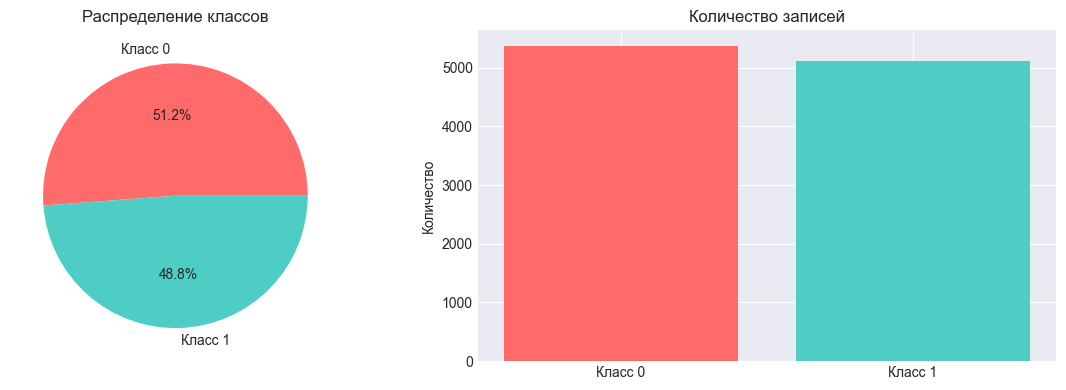

In [16]:
train = pd.read_csv('datasets/train_c.csv')
test = pd.read_csv('datasets/test_c.csv')

target_col = 'LoanApproved'

print(f"Размер train: {train.shape}, test: {test.shape}")
print(f"Целевая переменная: {target_col}")

train_clean = train.dropna(subset=[target_col]).copy()
train_clean[target_col] = train_clean[target_col].astype(int)

class_counts = train_clean[target_col].value_counts()
print(f"\nРаспределение классов:")
print(f"0: {class_counts[0]} ({class_counts[0]/len(train_clean)*100:.1f}%)")
print(f"1: {class_counts[1]} ({class_counts[1]/len(train_clean)*100:.1f}%)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.pie(class_counts, labels=['Класс 0', 'Класс 1'], autopct='%1.1f%%', colors=['#ff6b6b', '#4ecdc4'])
ax1.set_title('Распределение классов')

ax2.bar(['Класс 0', 'Класс 1'], class_counts, color=['#ff6b6b', '#4ecdc4'])
ax2.set_title('Количество записей')
ax2.set_ylabel('Количество')
plt.tight_layout()
plt.show()

In [17]:
def extract_date_features(df, col='ApplicationDate'):
    if col not in df.columns:
        return df
    
    dates = pd.to_datetime(df[col], errors='coerce')
    fallback_date = dates.mode()[0] if not dates.mode().empty else dates.min()
    dates = dates.fillna(fallback_date)
    
    new_features = {
        f'{col}_Year': dates.dt.year,
        f'{col}_Month': dates.dt.month,
        f'{col}_Quarter': dates.dt.quarter,
        f'{col}_Week': dates.dt.isocalendar().week.astype(float)
    }
    
    day_of_week = dates.dt.dayofweek
    angle = 2 * np.pi * day_of_week / 7.0
    new_features[f'{col}_DayOfWeek_Sin'] = np.sin(angle)
    new_features[f'{col}_DayOfWeek_Cos'] = np.cos(angle)
    
    return df.assign(**new_features).drop(columns=[col])

def preprocess_advanced(df, is_train=True, stats=None):
    EPS = 1e-5
    df = df.copy()
    quantiles = stats if stats is not None else {}
    
    if 'EducationLevel' in df.columns:
        education_mapping = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
        df['EducationLevel'] = df['EducationLevel'].map(education_mapping).fillna(0).astype(int)
    
    nominal_cols = ['HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus']
    cols_to_encode = [c for c in nominal_cols if c in df.columns]
    if cols_to_encode:
        df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True, dtype=int)
    
    if 'ApplicationDate' in df.columns:
        df = extract_date_features(df, 'ApplicationDate')
    
    df = df.fillna(df.mean(numeric_only=True))
    
    if 'InterestRate' in df.columns and 'BaseInterestRate' in df.columns:
        df['InterestRateSpread'] = df['InterestRate'] - df['BaseInterestRate']
    
    if 'AnnualIncome' in df.columns:
        if 'LoanAmount' in df.columns:
            df['LoanToIncome'] = df['LoanAmount'] / (df['AnnualIncome'] + EPS)
        if 'NetWorth' in df.columns:
            df['NetWorthToIncome'] = df['NetWorth'] / (df['AnnualIncome'] + EPS)
    
    if all(col in df.columns for col in ['MonthlyIncome', 'MonthlyLoanPayment', 'MonthlyDebtPayments']):
        total_debt = df['MonthlyLoanPayment'] + df['MonthlyDebtPayments']
        disposable = df['MonthlyIncome'] - total_debt
        df['DebtServiceRatio'] = total_debt / (df['MonthlyIncome'] + EPS)
        df['DisposableIncome'] = disposable
    
    cols_to_log = ['AnnualIncome', 'MonthlyLoanPayment', 'MonthlyDebtPayments', 'TotalAssets', 'TotalLiabilities', 'LoanAmount']
    for col in cols_to_log:
        if col in df.columns:
            df[col] = np.sign(df[col]) * np.log1p(np.abs(df[col]))
    
    drop_cols = ['ID', 'MaritalStatus', 'BaseInterestRate']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    
    df = df.fillna(0)
    
    return df, quantiles

In [18]:
y = train_clean[target_col]
X = train_clean.drop(columns=[target_col])
X_test_raw = test.copy()

X, stats = preprocess_advanced(X, is_train=True)
X_test_raw, _ = preprocess_advanced(X_test_raw, is_train=False, stats=stats)

train_cols = X.columns.tolist()
for col in train_cols:
    if col not in X_test_raw.columns:
        X_test_raw[col] = 0
X_test_raw = X_test_raw[train_cols]

print(f"После предобработки:")
print(f"X_train: {X.shape}, X_test: {X_test_raw.shape}")
print(f"Признаков: {X.shape[1]}")

После предобработки:
X_train: (10487, 48), X_test: (5000, 48)
Признаков: 48


In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_raw.values)

print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Валидационная выборка: {X_val.shape[0]} записей")

Обучающая выборка: 8389 записей
Валидационная выборка: 2098 записей


In [20]:
best_auc = 0
best_model = None
best_c = 0

C_values = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20]
print("Подбор параметра C:")
print(f"{'C':<8} {'ROC-AUC':<12} {'Accuracy':<12}")
print("-" * 35)

for C in C_values:
    model = LogisticRegression(
        C=C,
        max_iter=1000,
        random_state=42,
        solver='lbfgs',
        class_weight='balanced'
    )
    
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    y_pred = model.predict(X_val_scaled)
    
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"{C:<8.3f} {roc_auc:<12.4f} {accuracy:<12.4f}")
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model = model
        best_c = C

print("-" * 35)
print(f"Лучший C: {best_c}, ROC-AUC: {best_auc:.4f}")

Подбор параметра C:
C        ROC-AUC      Accuracy    
-----------------------------------
0.001    0.9752       0.9080      
0.010    0.9785       0.9214      
0.100    0.9802       0.9295      
0.500    0.9813       0.9247      
1.000    0.9816       0.9252      
2.000    0.9817       0.9247      
5.000    0.9817       0.9252      
10.000   0.9818       0.9247      
20.000   0.9817       0.9256      
-----------------------------------
Лучший C: 10, ROC-AUC: 0.9818


In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    best_model, X_train_scaled, y_train, 
    cv=cv, scoring='roc_auc', n_jobs=-1
)

print("Кросс-валидация (5-fold):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Средний ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Кросс-валидация (5-fold):
  Fold 1: 0.9848
  Fold 2: 0.9889
  Fold 3: 0.9845
  Fold 4: 0.9849
  Fold 5: 0.9854
Средний ROC-AUC: 0.9857 ± 0.0016


In [22]:
y_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
y_pred = best_model.predict(X_val_scaled)

roc_auc = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("\nМетрики на валидации:")
print(f"ROC-AUC:          {roc_auc:.4f}")
print(f"Accuracy:         {accuracy:.4f}")
print(f"Precision:        {precision:.4f}")
print(f"Recall:           {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Класс 0', 'Класс 1']))


Метрики на валидации:
ROC-AUC:          0.9818
Accuracy:         0.9247
Precision:        0.9321
Recall:           0.9199
F1-Score:         0.9260

Classification Report:
              precision    recall  f1-score   support

     Класс 0       0.92      0.93      0.92      1024
     Класс 1       0.93      0.92      0.93      1074

    accuracy                           0.92      2098
   macro avg       0.92      0.92      0.92      2098
weighted avg       0.92      0.92      0.92      2098



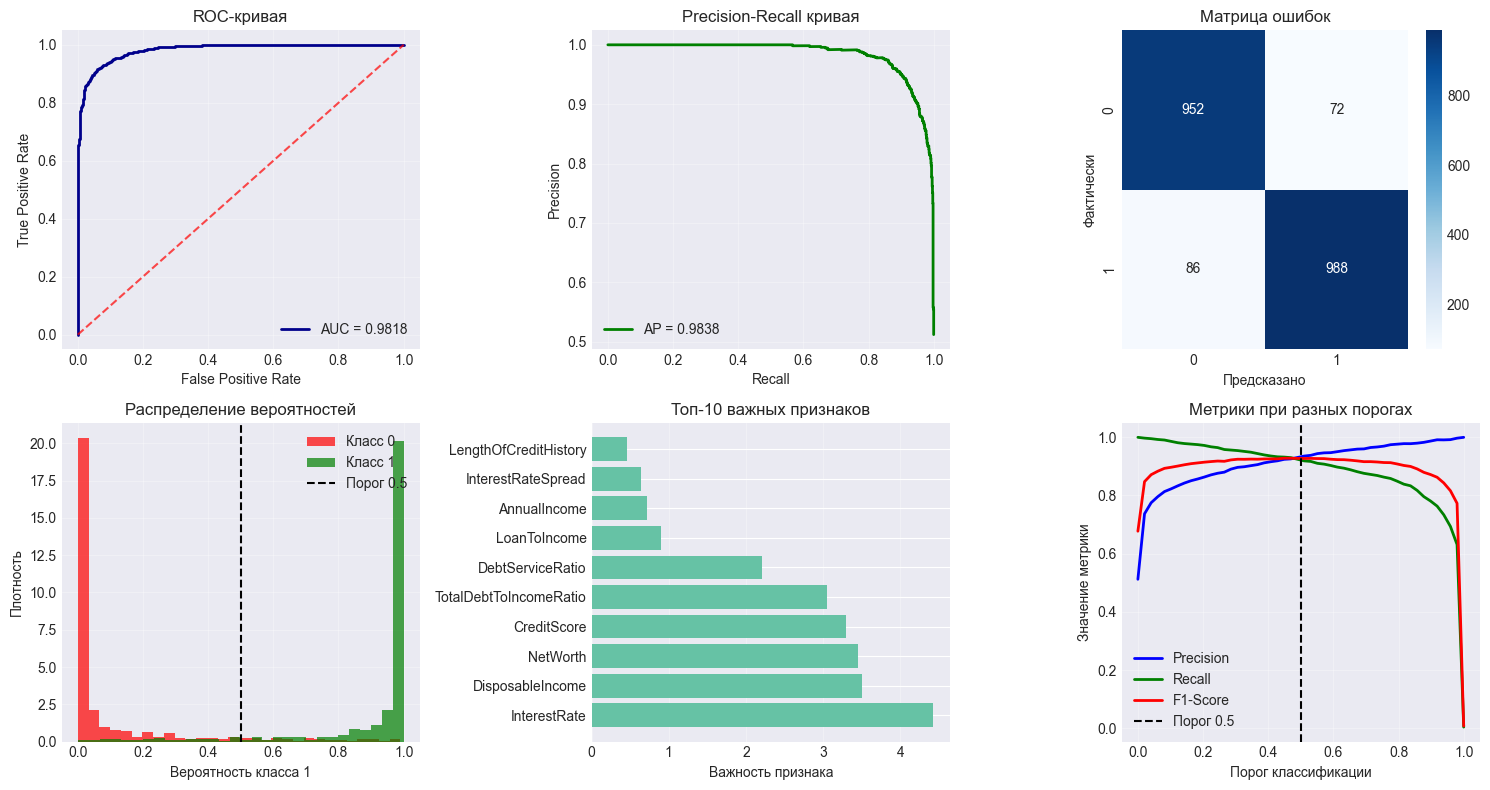

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
axes[0,0].plot(fpr, tpr, color='darkblue', lw=2, label=f'AUC = {roc_auc:.4f}')
axes[0,0].plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.7)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC-кривая')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_proba)
ap = average_precision_score(y_val, y_pred_proba)
axes[0,1].plot(recall_vals, precision_vals, color='green', lw=2, label=f'AP = {ap:.4f}')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall кривая')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2])
axes[0,2].set_title('Матрица ошибок')
axes[0,2].set_xlabel('Предсказано')
axes[0,2].set_ylabel('Фактически')

axes[1,0].hist(y_pred_proba[y_val == 0], bins=30, alpha=0.7, color='red', label='Класс 0', density=True)
axes[1,0].hist(y_pred_proba[y_val == 1], bins=30, alpha=0.7, color='green', label='Класс 1', density=True)
axes[1,0].axvline(x=0.5, color='black', linestyle='--', label='Порог 0.5')
axes[1,0].set_xlabel('Вероятность класса 1')
axes[1,0].set_ylabel('Плотность')
axes[1,0].set_title('Распределение вероятностей')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

feature_importance = pd.DataFrame({
    'feature': train_cols,
    'importance': np.abs(best_model.coef_[0])
}).sort_values('importance', ascending=False).head(10)

axes[1,1].barh(range(len(feature_importance)), feature_importance['importance'].values)
axes[1,1].set_yticks(range(len(feature_importance)))
axes[1,1].set_yticklabels(feature_importance['feature'].values)
axes[1,1].set_xlabel('Важность признака')
axes[1,1].set_title('Топ-10 важных признаков')
axes[1,1].grid(alpha=0.3, axis='x')

thresholds = np.linspace(0, 1, 50)
precisions, recalls, f1_scores = [], [], []
for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_thresh))
    f1_scores.append(f1_score(y_val, y_pred_thresh))

axes[1,2].plot(thresholds, precisions, 'b-', label='Precision', lw=2)
axes[1,2].plot(thresholds, recalls, 'g-', label='Recall', lw=2)
axes[1,2].plot(thresholds, f1_scores, 'r-', label='F1-Score', lw=2)
axes[1,2].axvline(x=0.5, color='black', linestyle='--', label='Порог 0.5')
axes[1,2].set_xlabel('Порог классификации')
axes[1,2].set_ylabel('Значение метрики')
axes[1,2].set_title('Метрики при разных порогах')
axes[1,2].legend()
axes[1,2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
test_predictions = best_model.predict(X_test_scaled)

print("Статистика предсказаний:")
print(f"Средняя вероятность: {test_proba.mean():.4f}")
print(f"Предсказано класса 0: {np.sum(test_predictions == 0)} ({np.sum(test_predictions == 0)/len(test_predictions)*100:.1f}%)")
print(f"Предсказано класса 1: {np.sum(test_predictions == 1)} ({np.sum(test_predictions == 1)/len(test_predictions)*100:.1f}%)")

test_ids = test['ID'] if 'ID' in test.columns else pd.Series(range(1, len(test)+1))
submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions
})

submission.to_csv('submission2.csv', index=False)

print(f"\nРезультаты сохранены в submission_classification.csv")
print(f"ROC-AUC на валидации: {roc_auc:.4f}")

Статистика предсказаний:
Средняя вероятность: 0.5133
Предсказано класса 0: 2434 (48.7%)
Предсказано класса 1: 2566 (51.3%)

Результаты сохранены в submission_classification.csv
ROC-AUC на валидации: 0.9818
